# Behaviour Driving

The goal of this project is to teach a virtual vehicle to drive using only the driving data that we have collected in a simulator. This idea is most recently based on a paper by NVIDIA called [End To End Driving For Self-Driving Cars](https://arxiv.org/abs/1604.07316).

Useful Resources:
* [Steering Ratio](https://en.wikipedia.org/wiki/Steering_ratio)

## Loading The Dataset

In [1]:
# Visualizations will be shown in the notebook.
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2

In [2]:
path = '../datasets/behavioural_driving/Dataset_2'
standard_path = '../datasets/behavioural_driving/Dataset_2'
recovery_path = '../datasets/behavioural_driving/Recovery_Driving'
udacity_path = "../datasets/behavioural_driving/Udacity/data"
img_path = path + '/IMG'
models_path = "./models"

In [3]:
# TODO load recovery and udacity datasets
# TODO compare them all
# Merge them all
def load_csv(file_path, col_names, remove_header=False):
    csv = pd.read_csv(file_path, header=None, names=col_names)
    if remove_header:
        csv = csv[1:]
    
    return csv

In [4]:
# Define our column headers
col_header_names = ["Center", "Left", "Right", "Steering Angle", "Throttle", "Brake","Speed"]

In [5]:
# Let's load our standard driving dataset, where we drive in both directions
standard_csv = load_csv(standard_path + "/driving_log.csv", col_header_names)
standard_csv["Steering Angle"] = standard_csv["Steering Angle"].astype(float) 
print("Standard dataset has {0} rows".format(len(standard_csv)))

Standard dataset has 12979 rows


In [6]:
# Let's load the data set of driving in recovery mode (aka virtual drink driving dataset)
recovery_csv = load_csv(recovery_path + "/driving_log.csv", col_header_names)
recovery_csv["Steering Angle"] = recovery_csv["Steering Angle"].astype(float) 
print("Recovery dataset has {0} rows".format(len(recovery_csv)))

Recovery dataset has 3546 rows


In [7]:
# Finally let's load the udacity dataset
udacity_csv = load_csv(udacity_path + "/driving_log.csv", col_header_names, remove_header=True)
udacity_csv["Steering Angle"] = udacity_csv["Steering Angle"].astype(float) 
print("Standard dataset has {0} rows".format(len(udacity_csv)))

Standard dataset has 8036 rows


In [ ]:
data_csv = pd.read_csv(path + '/driving_log.csv', header=None, 
                       names = ["Center", "Left", "Right", "Steering Angle", "Throttle", "Brake","Speed"])

In [ ]:
data_csv = data_csv[1:]


In [ ]:
data_csv.head(n=10)

In [ ]:
img_count = data_csv.shape[0]
print("Dataset counts {0} rows".format(img_count))

In [ ]:
data_csv["Steering Angle"] = data_csv["Steering Angle"].astype(float) 

## Investigation distribution of stearing angles

Let's investigate the distribution of our steering angle data.

In [8]:
def get_steering_angles(data, st_column, st_calibrations, filtering_f=None):
    """
    Returns the steering angles for images referenced by the dataframe
    The caller must pass the name of the colum containing the steering angle 
    along with the appropriate steering angle corrections to apply
    """
    cols = len(st_calibrations)
    print("CALIBRATIONS={0}, ROWS={1}".format(cols, data.shape[0]))
    angles = np.zeros(data.shape[0] * cols, dtype=np.float32)
    
    i = 0
    for indx, row in data.iterrows():        
        st_angle = row[st_column]
        for (j,st_calib) in enumerate(st_calibrations):  
            angles[i * cols + j] = st_angle + st_calib
        i += 1
    
    # Let's not forget to ALWAYS clip our angles within the [-1,1] range
    return np.clip(angles, -1, 1)

In [ ]:
data_csv["Steering Angle"][2100]

In [ ]:
st_angles_with_calibrations = get_steering_angles(data_csv, "Steering Angle", st_angle_calibrations)
st_angles_without_calibrations = get_steering_angles(data_csv, "Steering Angle", [0])

In [35]:
st_angle_names = ["Center", "Left", "Right"]
st_angle_calibrations = [0, 0.25, -0.25]

In [9]:
standard_st_angles_without_calibrations = get_steering_angles(standard_csv, "Steering Angle", [0])
recovery_st_angles_without_calibrations = get_steering_angles(recovery_csv, "Steering Angle", [0])
udacity_st_angles_without_calibrations = get_steering_angles(udacity_csv, "Steering Angle", [0])

CALIBRATIONS=1, ROWS=12979
CALIBRATIONS=1, ROWS=3546
CALIBRATIONS=1, ROWS=8036


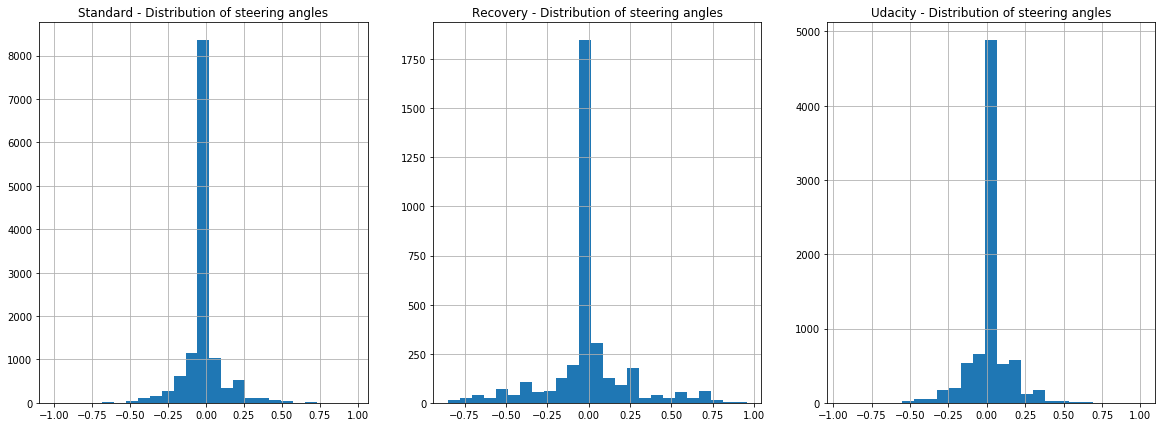

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].grid(True)
ax[0].set(title="Standard - Distribution of steering angles")
count, bins, _ = ax[0].hist(standard_st_angles_without_calibrations, bins=25,histtype='bar' )

ax[1].grid(True)
ax[1].set(title="Recovery - Distribution of steering angles")
count, bins, _ = ax[1].hist(recovery_st_angles_without_calibrations, bins=25,histtype='bar' )

ax[2].grid(True)
ax[2].set(title="Udacity - Distribution of steering angles")
count, bins, _ = ax[2].hist(udacity_st_angles_without_calibrations, bins=25,histtype='bar' )

The recovery dataset shows the most variability, as expected in the steering angle data. However, all three distributions show greatly imbalanced dataset, where the neutral angle (i.e. 0) overwhelmingly dwarfes all other angles. **This means, that unless we take corrective steps, our model will be biased to driving straight.**

Let's try to merge them all and see what the distribution of this *ensemble* dataset looks like.

In [11]:
frames = [recovery_csv, udacity_csv]
ensemble_csv = pd.concat(frames)
len(ensemble_csv)

11582

In [12]:
ensemble_st_angles_without_calibrations = get_steering_angles(ensemble_csv, "Steering Angle", [0])

CALIBRATIONS=1, ROWS=11582


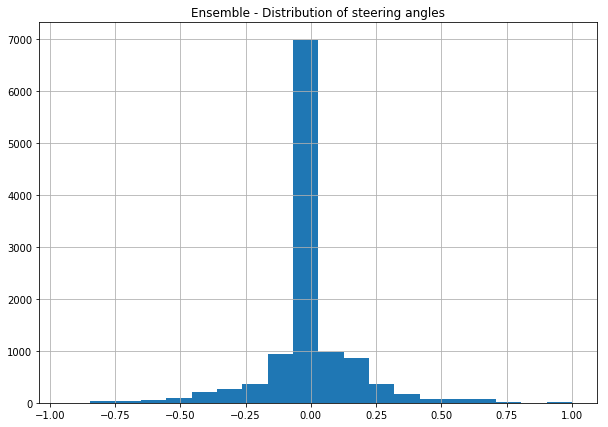

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.grid(True)
ax.set(title="Ensemble - Distribution of steering angles")
count, bins, _ = ax.hist(ensemble_st_angles_without_calibrations, bins=20, histtype='bar')

Once again, the dataset is greatly imbalanced. Neutral angles are overwhelmingly present and there is also a bias towards turning left.

## Load Images

We define a simple function that loads the images given the path.

In [17]:
def read_img(img_full_path, img_dir="/IMG"):
    prefix_path = udacity_path + img_dir

    if "Dataset_2" in img_full_path:
        prefix_path = standard_path + img_dir
    elif "Recovery_Driving" in img_full_path:
        prefix_path = recovery_path + img_dir
    
    img_path = "{0}/{1}".format(prefix_path, img_full_path.split("/")[-1])
    
    img = cv2.imread(img_path)
    # Converting image to RGB
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Build A Generator

We are going to build a Keras generator to be able to perform real-time augmentations when training the model. The first step we have to do though is to define all our augmentations.

### Implementation Image Augmentation Functions

In [18]:
def fliph_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)

In [19]:
def blur_image(img, f_size=5):
    """
    Applies Gaussir Blur to smoothen the image.
    This in effect performs anti-aliasing on the provided image
    """
    img = cv2.GaussianBlur(img,(f_size, f_size),0)
    img = np.clip(img, 0, 255)

    return img.astype(np.uint8)

In [104]:

# Read more about it here: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate_image(img, st_angle, low_x_range, high_x_range, low_y_range, high_y_range, delta_st_angle_per_px):
    rows, cols = (img.shape[0], img.shape[1])
    translation_x = np.random.randint(low_x_range, high_x_range) 
    translation_y = np.random.randint(low_y_range, high_y_range) 
    
    st_angle += translation_x * delta_st_angle_per_px

    translation_matrix = np.float32([[1, 0, translation_x],[0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    
    return img, st_angle

In [21]:
def change_image_lightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'L' component of the supplied image in HSL format
    The returned image in converted back to RGB
    """
    # Convert to HSL (HLS in OpenCV!!)
    hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
    hls = hls.astype(int)    
    
    # Add an offset to light component 
    offset = np.random.randint(low, high=high)
    # Since the format is HLS and NOT HSL, it is the second component (index 1) that is modified
    hls[:,:,1] += offset

    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hls, 0, 255)
    
    # Convert back to uint
    hls = hls.astype(np.uint8)
    
    # Make sure we return image in RGB format
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB) 

In [22]:
def change_image_brightness(img, low, high):
    # Convert to HSV
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv = hsv.astype(int)    
    
    # Adding the offset to the v component
    offset = np.random.randint(low, high=high)
    hsv[:,:,2] += offset
    
    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hsv, 0, 255)
    
    # Convert back to uint
    hsv = hsv.astype(np.uint8)
    
    # Make sure we return image in RGB format
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) 

In [23]:
def add_shadow(img, s_min=0.3, s_max=0.8):
    img = img.astype(np.float32)
    
    height = img.shape[0]
    width = img.shape[1]
    width_stop = np.random.randint(0, width)
    s = np.random.uniform(s_min, s_max)
    
    if np.random.random_sample() < 0.5:
        img[:,0:width_stop,:] *= s
    else:
        img[:,width_stop:width,:] *= s
    
    img = img.astype(np.uint8)
    return img

In [24]:
def shift_horizon(img, h_s=0.2):
    img = img.astype(np.float32)
    
    # randomly shift horizon
    height = img.shape[0]
    width = img.shape[1]
    horizon = h_s * height / 3
    v_shift = np.random.randint(-height/8,height/8)
    pts1 = np.float32([[0, horizon],[width, horizon], [0, height], [width, height]])
    pts2 = np.float32([[0, horizon + v_shift],[width, horizon + v_shift], [0, height], [width, height]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M,(width, height), borderMode=cv2.BORDER_REPLICATE)
    
    return img.astype(np.uint8)

In [25]:
def change_gamma(img, gamma=0.5):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    img = img.astype(np.float32) 
    img /= 255.0
    
    #img[:,:100,:] = img[:,:100,:] ** invGamma
    #img *= 255
    #img = img.astype(np.uint8)
    img = cv2.bitwise_and(img * 255, img * 255, mask=img[:,:100,:] ** invGamma)
    return img
    
    #table = np.array([((i / 255.0) ** invGamma) * 255
    #for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(img, table)

In [26]:
def change_brightness_rgb(img, s=0.5):
    img = img.astype(np.float32)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

In [171]:
def augment_image(img, st_angle, p=1.0):
    """
    Augment a given image with a probability p
    """
    aug_img = img
    
    #if np.random.random_sample() <= 1.0:
        # Reduce aliasing via blurring
        #aug_img = blur_image(aug_img)
   
    if np.random.random_sample() <= 0.5: 
        # Horizontally flip image
        aug_img = fliph_image(aug_img)
        st_angle = -st_angle
     
    if np.random.random_sample() <= 0.5:
        # Change image brightness or lightness
        low = -np.random.randint(25, high=75)
        high = np.random.randint(25, high=75)
        if np.random.random_sample() <= 0.5:
            # Try changes in lightness
            aug_img = change_image_lightness(aug_img, low, high)
        else:
            # Try changes in brightness
            aug_img = change_image_brightness(aug_img, low, high)
    

    if np.random.random_sample() <= 0.5: 
        # TODO adding shadows        
        aug_img = add_shadow(aug_img)
        
    # Shift the image left/right, up/down and modify the steering angle accordingly
    if np.random.random_sample() <= 0.5:
        aug_img, st_angle = translate_image(aug_img, st_angle, -100, 101, -20, 21, 0.40/100)
    
    # TODO Try adding slight rotations
        
    return aug_img, st_angle

In [172]:
from sklearn.utils import shuffle
def generate_images(df, target_dimensions, img_types, st_column, st_angle_calibrations, batch_size=100, shuffle=True):
    """
    Generates images whose paths and steering angle are stored in supplied dataframe object df
    Returns the tuple (batch,steering_angles)
    """
    # e.g. 160x320x3 for target_dimensions
    batch = np.zeros((batch_size, target_dimensions[0],  target_dimensions[1],  target_dimensions[2]), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    df_len = len(df)
    img_types = ["Center", "Left", "Right"]
    st_angle_calibrations = [0, 0.25, -0.25]
    aug_pct = 0.8
    max_steering_calib_offset = 3
    
    while True:
        k = 0
        while k < batch_size:            
            idx = np.random.randint(0, df_len)       

            for img_t, st_calib in zip(img_types, st_angle_calibrations):
                if k >= batch_size:
                    break
                                
                row = df.iloc[idx]
                st_angle = row[st_column]            
                
                # Drop neutral-ish steering angle images with some probability
                if abs(st_angle) < 0.05 and np.random.random_sample() <= 0.50 :
                    continue
                    
                st_angle += st_calib
                                                
                # Making sure we offset the data
                #calib_offset = float(np.random.randint(-max_steering_calib_offset, high=max_steering_calib_offset + 1)) / 100.0
                #st_calib = st_calib + (st_calib * calib_offset)                
                
                img_type_path = row[img_t]  
                img = read_img(img_type_path)                
                
                # Resize image
                
                
                img, st_angle = augment_image(img, st_angle, p=0.5) if np.random.random_sample() <= aug_pct else (img, st_angle)
                batch[k] = img
                steering_angles[k] = st_angle
                k += 1
        
        # Reshuffling results to make sure center, left and right image for a same row are in a sequence       
        #permutation = np.random.permutation(batch.shape[0])
        #batch = batch[permutation]
        #steering_angles = steering_angles[permutation]
        
        yield batch, np.clip(steering_angles, -1, 1)            

### Viewing Some Of Our Augmented Images

We view the results of the augmentations in this section.

In [40]:
def show_images(imgs, labels, cols=5, fig_size=(15, 5)):
    rows = len(imgs) // cols
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    for r in range(rows):
        for c in range(cols):
            ax = axes[r,c]
            img = imgs[cols * r + c]
            lb = labels[cols * r + c]
            ax.imshow(img.astype(np.uint8))
            ax.axis('on')
            ax.set_aspect('equal')
            ax.set(title=lb)
    fig.tight_layout()
    plt.show()
    

In [173]:
b_divider = 45
b_size = len(ensemble_csv)  * 3 // b_divider
b_size

772

In [175]:
gen = generate_images(ensemble_csv, (160, 320, 3), st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size)

In [176]:
b, s = next(gen)

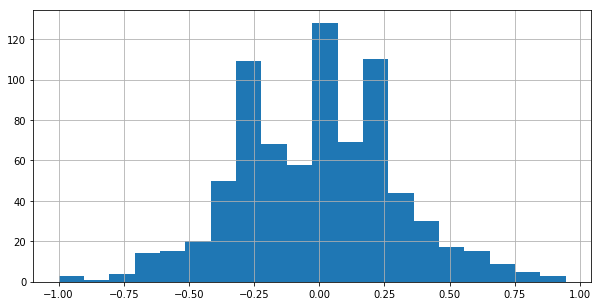

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(True)
count, bins, _ = ax.hist(s, bins=20,histtype='bar' )

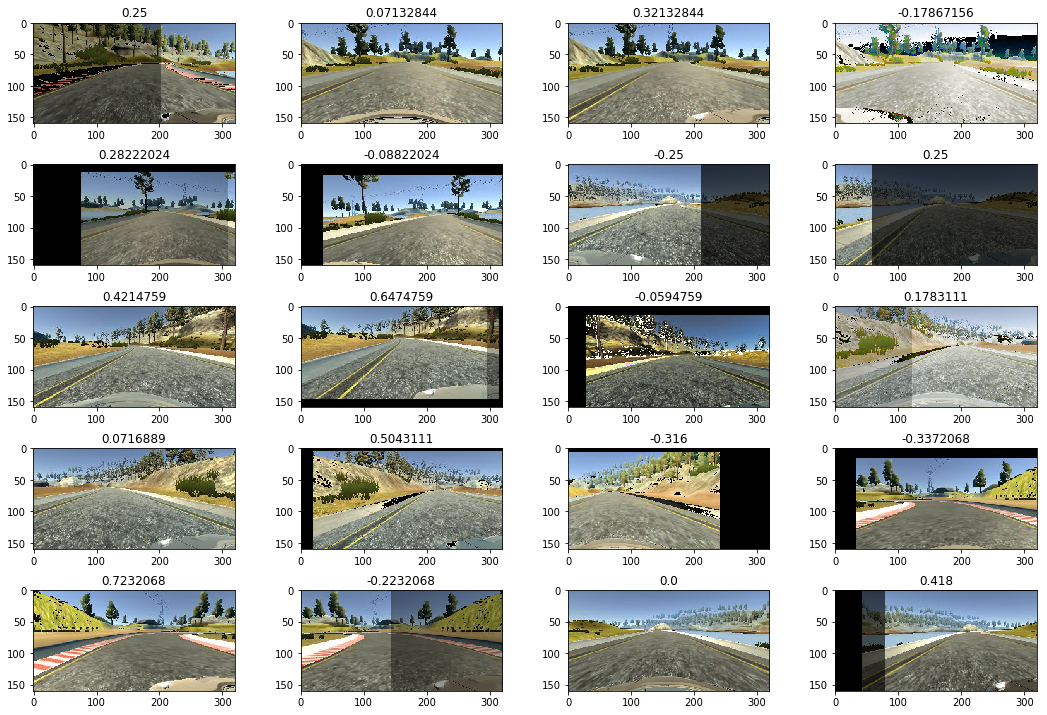

In [178]:
show_images(b[100:120], s[100:120], cols=4, fig_size=(15, 10))

We can observe that the images are well augmented. This should hopefully help our model generalise

## Build A Neural Net To Predict Steering Angles

We are using Keras, which in turn delegates to Tensorflow under the hood. Let's import all the functions we need.

In [42]:
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [43]:
# Let's also define the input shape
in_shape = (160, 320, 3)

### Simple Model

In this section we create a simple model to predict steering angles. There are no convolutions in this architecture, and since this is a pure _regression_ problem, and not a _classification_ one, we will be using the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the activation function in the last layer.

In [ ]:
def simple_model():
    model = Sequential()
    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = "adam", metrics=['accuracy'])
    return model

In [ ]:
m = simple_model()
history = m.fit(X_train, y_train, nb_epoch=50, validation_split=0.2, shuffle=True, verbose=0)

In [ ]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_acc'])

In [ ]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_loss'])

In [ ]:
m.save("{0}/simple_model.h5".format(models_path))

In [ ]:
def plot_results(hist, metrics, xlb, ylb, title, leg, fsize = (10, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    for m in metrics:        
        ax.plot(hist.history[m])
    
    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.set_yscale('log')

    ax.legend(leg, loc='upper left')
    plt.show()

In [ ]:
plot_results(history, ["acc", "val_acc"], "epoch", "accuracy", "Accuracy vs Epochs", ["Training", "Validation"])

In [ ]:
plot_results(history, ["loss", "val_loss"], "epoch", "loss", "Loss vs Epochs", ["Training", "Validation"])

We are not getting a stable network at all. The loss is erratic as well as the accuracy, and we are barely reaching 0.1% on the training set. We will explore next the architecture employed by the team from the NVIDIA paper.

## NVIDIA Model

### Pre-processing steps

In [ ]:
mean_channels = [mean_r, mean_g, mean_b]
print("Mean for channels is {0}".format(mean_channels))

In [ ]:
def crop(imgs):
    return imgs[:,crop_y_start:,:,:]

In [60]:
def resize(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [66, 200])

In [61]:
def resize_sq(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [66, 66])

In [ ]:
def normalize_mean_channels(img):
    return img - [136.19009391165321, 142.25525395939627, 133.84246425028346]

In [129]:
def nvidia_model():
    model = Sequential()
    # Cropping image
    model.add(Lambda(lambda imgs: imgs[:,80:,:,:], input_shape=(160, 320, 3)))
    # Normalise the image - center the mean at 0
    model.add(Lambda(lambda imgs: (imgs/255.0)))
    model.add(Lambda(resize))
    
    # TODO use Keras.Cropping instead of a lambda layer

    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))    
    model.add(BatchNormalization())

    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu')) 
    model.add(BatchNormalization())

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu')) 
    model.add(BatchNormalization())
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(1164, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(10, activation='relu'))
    model.add(BatchNormalization())
    
    # Output layer
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = Adam(lr = 0.001))
    return model 

In [75]:
def conv_model_2():
    from keras.backend import tf as ktf
    
    model = Sequential()
    # Cropping image
    model.add(Lambda(lambda imgs: imgs[:,80:140,:,:], input_shape=(160, 320, 3)))
    # Normalise the image - center the mean at 0
    model.add(Lambda(lambda imgs: (imgs/255.0) - 0.5))
    
    model.add(Lambda(resize_sq))
    #model.add(Lambda(lambda imgs: ktf.image.resize_images(imgs, [66, 66])))
    
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    
    # Flattening the output of last convolutional layer before entering fully connected phase
    model.add(Flatten())
    
    # Fully connected layers    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
        
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    
    # Output layer
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = Adam(lr = 0.001))
    return model 

In [179]:
m = nvidia_model()

In [154]:
m2 = conv_model_2()

In [ ]:
m2.summary()

In [ ]:
m.summary()

In [180]:
gen = generate_images(ensemble_csv, in_shape, st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size)

In [144]:
m2.fit_generator(gen, samples_per_epoch=b_size * b_divider, nb_epoch=5, verbose=1)

Epoch 1/5
34740/34740 [==============================] - 87s - loss: 0.2506    
Epoch 2/5
34740/34740 [==============================] - 86s - loss: 0.0665    
Epoch 3/5
34740/34740 [==============================] - 86s - loss: 0.0591    
Epoch 4/5
34740/34740 [==============================] - 86s - loss: 0.0568    
Epoch 5/5
34740/34740 [==============================] - 86s - loss: 0.0532    


In [145]:
m2.save("{0}/ed_vgg.h5".format(models_path))

In [ ]:
m.fit_generator(gen, samples_per_epoch=b_size * b_divider, nb_epoch=10, verbose=1)

Epoch 1/10
34740/34740 [==============================] - 86s - loss: 0.1362    
Epoch 2/10
34740/34740 [==============================] - 86s - loss: 0.0516    
Epoch 3/10
34740/34740 [==============================] - 86s - loss: 0.0451    
Epoch 4/10
34740/34740 [==============================] - 86s - loss: 0.0411    
Epoch 5/10
32424/34740 [===========================>..] - ETA: 5s - loss: 0.0396

In [170]:
m.save("{0}/nvida_model_1.h5".format(models_path))

In [ ]:
from keras.models import load_model,model_from_json

In [ ]:
#m2 = load_model("{0}/nivida_model.h5".format(models_path), custom_objects={"tf": backend.tf})
m2 = load_model("{0}/nivida_model_4.h5".format(models_path))

In [ ]:
model2 = model_from_json(m.to_json(), custom_objects={"ktf.image.resize_images": ktf.image.resize_images})